<a href="https://colab.research.google.com/github/bsshreesha/Physics_Informed_Neural_Network/blob/main/Reinforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [40]:
# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

In [42]:
# Define the PINN model
class PINN(tf.keras.Model):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden = [tf.keras.layers.Dense(neuron, activation='tanh') for neuron in layers[:-1]]
        self.out = tf.keras.layers.Dense(layers[-1], activation=None)

    def call(self, x):
        z = x
        for layer in self.hidden:
            z = layer(z)
        output = self.out(z)
        return output

# Define the n-th order derivative calculation
def nth_derivative(model, x, n):
    y = model(x)
    for _ in range(n):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            y = model(x)  # Re-compute the model output
        y = tape.gradient(y, x)
    return y

In [43]:
# Define the loss function for PDE/ODE
def compute_loss(model, X_f, equation_func, boundary_X, boundary_func):
    # Compute the model output
    u = model(X_f)

    # Calculate derivatives up to 10th order
    derivatives = [nth_derivative(model, X_f, i) for i in range(1, 11)]  # Up to 10th derivative

    # PDE residual
    f = equation_func(X_f, u, *derivatives)

    # Boundary loss
    u_boundary = model(boundary_X)
    boundary_loss = tf.reduce_mean(tf.square(u_boundary - boundary_func(boundary_X)))

    # Total Loss
    loss_f = tf.reduce_mean(tf.square(f))
    total_loss = loss_f + boundary_loss

    return total_loss, loss_f, boundary_loss

In [44]:
# Reinforcement learning inspired Training Step
@tf.function
def train_step(model, optimizer, X_f, equation_func, boundary_X, boundary_func):
    with tf.GradientTape() as tape:
        total_loss, loss_f, boundary_loss = compute_loss(model, X_f, equation_func, boundary_X, boundary_func)

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    reward = 1.0 / (1.0 + total_loss)  # Higher reward for smaller loss
    return total_loss, reward

In [45]:
# -------- Burger's Equation (Nonlinear PDE) --------
def burgers_equation(X, u, u_x, u_xx):
    nu = 0.01  # Kinematic viscosity, example
    return u_xx - u * u_x + nu * u_xx  # Nonlinear term u*u_x

# -------- Navier-Stokes Equation --------
def navier_stokes(X, u, u_x, u_xx, u_y, u_yy):
    rho = 1.0  # Density
    mu = 0.1   # Dynamic viscosity
    return u_xx + u_yy - (u * u_x + u * u_y) + (mu / rho) * (u_xx + u_yy)

# Example boundary condition: u(0)=0, u(π)=0 for simple equations
def example_boundary(X):
    return tf.zeros_like(X)

# Generate training data
def generate_training_points(N_f=1000, N_b=100):
    X_f = tf.random.uniform((N_f, 1), 0, np.pi)
    boundary_X = tf.constant([[0.0], [np.pi]], dtype=tf.float32)
    return X_f, boundary_X

# Step-by-step solving function
def solve_and_plot(model, X_test):
    u_pred = model(X_test)
    plt.plot(X_test, u_pred, 'r-', label="Predicted solution")
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('PINN Solution')
    plt.legend()
    plt.show()

Epoch 0: Loss=0.043961, Reward=0.957890, Accuracy=64.35%
Epoch 13: Loss=0.000269, Reward=0.999731, Accuracy=99.98%
Target accuracy of 98.0% reached at epoch 13. Stopping training.


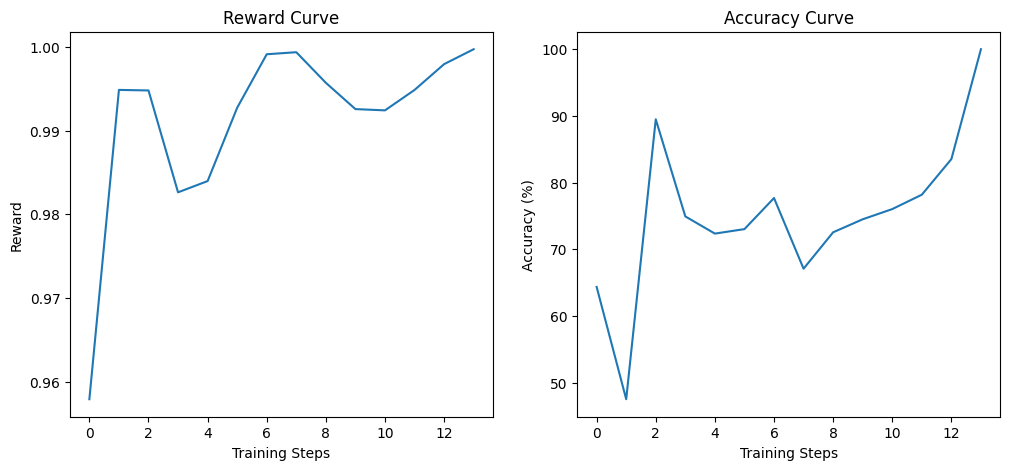

In [50]:
# --------- Main Training (with Accuracy and Early Stopping) -----------

layers = [1, 50, 50, 50, 1]  # Input -> 3 hidden layers -> Output
model = PINN(layers)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Generate training points
X_f_train, boundary_X = generate_training_points()

# Choose PDE and boundary
equation_func = burgers_equation
boundary_func = example_boundary

EPOCHS = 5000
rewards = []
accuracies = []

TARGET_ACCURACY = 98.0  # Stop training when this is achieved

for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:
        # Forward pass
        u = model(X_f_train)

        # Derivatives
        u_x = nth_derivative(model, X_f_train, 1)
        u_xx = nth_derivative(model, X_f_train, 2)

        # PDE residual
        f = equation_func(X_f_train, u, u_x, u_xx)

        # Boundary condition
        u_boundary = model(boundary_X)
        boundary_loss = tf.reduce_mean(tf.square(u_boundary - boundary_func(boundary_X)))

        # Losses
        loss_f = tf.reduce_mean(tf.square(f))
        total_loss = loss_f + boundary_loss

    # Update parameters
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Compute reward (inverse of loss)
    reward = 1.0 / (1.0 + total_loss)
    rewards.append(reward.numpy())

    # Calculate "accuracy" as (1 - normalized PDE error) * 100
    normalized_loss = tf.clip_by_value(loss_f / (loss_f + boundary_loss + 1e-8), 0.0, 1.0)
    accuracy = (1.0 - normalized_loss) * 100.0
    accuracies.append(accuracy.numpy())

    # Print every 500 epochs or when accuracy reaches target
    if epoch % 500 == 0 or accuracy >= TARGET_ACCURACY:
        print(f"Epoch {epoch}: Loss={total_loss.numpy():.6f}, Reward={reward.numpy():.6f}, Accuracy={accuracy.numpy():.2f}%")

    # Early stopping if accuracy target reached
    if accuracy >= TARGET_ACCURACY:
        print(f"Target accuracy of {TARGET_ACCURACY}% reached at epoch {epoch}. Stopping training.")
        break

# Plot rewards
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Reward Curve')
plt.xlabel('Training Steps')
plt.ylabel('Reward')

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Accuracy Curve')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy (%)')

plt.show()


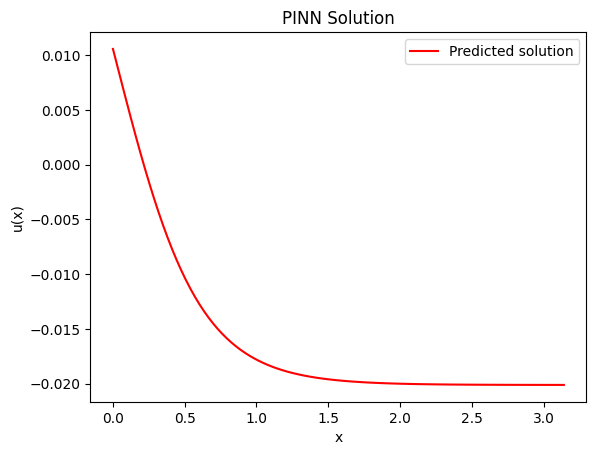

Saved artifact at '/tmp/tmphej3bcnw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138910404140816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138910404147152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138910404137168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138910404142352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138910404136208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138910404138128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138910404133904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138910404148112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138910404144848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138910404145040: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model saved for TensorLite Deploymen

In [51]:
# Plot the solution
X_test = tf.linspace(0.0, np.pi, 100)[:, None]
solve_and_plot(model, X_test)

# Save TFLite model for deployment later
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('pinn_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved for TensorLite Deployment ✅")